PERTEMUAN 4

Langkah 2 — Collection
Buka file CSV dengan Pandas dan tampilkan info dataset:

In [75]:
import pandas as pd
df = pd.read_csv("kelulusan_mahasiswa.csv")
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IPK                10 non-null     float64
 1   Jumlah_Absensi     10 non-null     int64  
 2   Waktu_Belajar_Jam  10 non-null     int64  
 3   Lulus              10 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 448.0 bytes
None
   IPK  Jumlah_Absensi  Waktu_Belajar_Jam  Lulus
0  3.8               3                 10      1
1  2.5               8                  5      0
2  3.4               4                  7      1
3  2.1              12                  2      0
4  3.9               2                 12      1


Langkah 3 — Cleaning
Periksa missing value dan tangani (isi median/modus).
Hapus data duplikat.
Identifikasi outlier dengan boxplot.

IPK                  0
Jumlah_Absensi       0
Waktu_Belajar_Jam    0
Lulus                0
dtype: int64


<Axes: xlabel='IPK'>

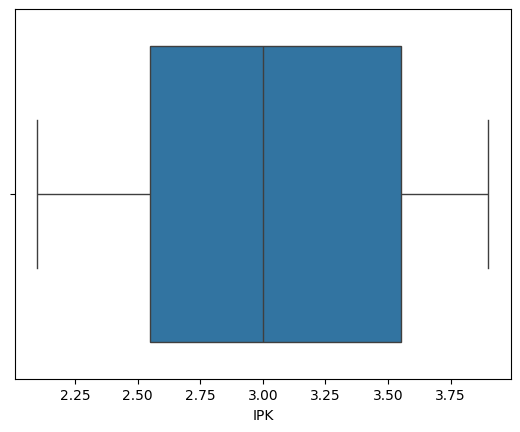

In [76]:
print(df.isnull().sum())
df = df.drop_duplicates()
df = df.dropna()

import seaborn as sns
sns.boxplot(x=df['IPK'], showfliers=True)

Langkah 4 — Exploratory Data Analysis (EDA)
Hitung statistik deskriptif.
Buat histogram distribusi IPK.
Visualisasi scatterplot (IPK vs Waktu Belajar).
Tampilkan heatmap korelasi.

             IPK  Jumlah_Absensi  Waktu_Belajar_Jam      Lulus
count  10.000000        10.00000          10.000000  10.000000
mean    3.030000         6.00000           6.400000   0.500000
std     0.639531         3.05505           3.306559   0.527046
min     2.100000         2.00000           2.000000   0.000000
25%     2.550000         4.00000           4.000000   0.000000
50%     3.000000         5.50000           6.000000   0.500000
75%     3.550000         7.75000           8.750000   1.000000
max     3.900000        12.00000          12.000000   1.000000


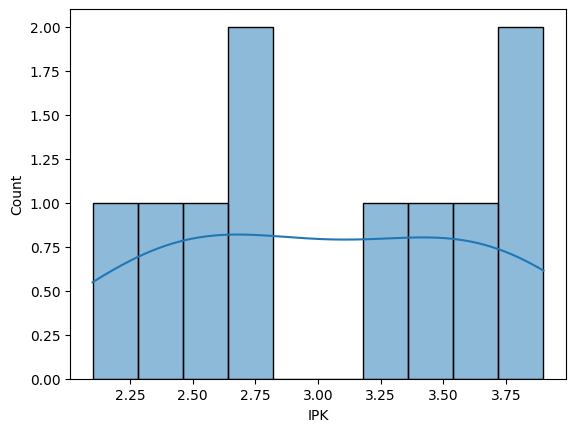

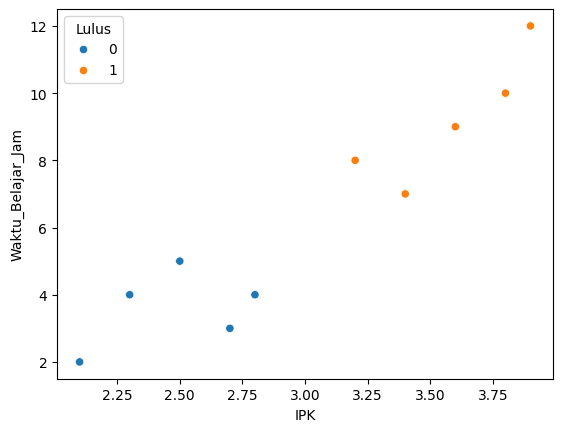

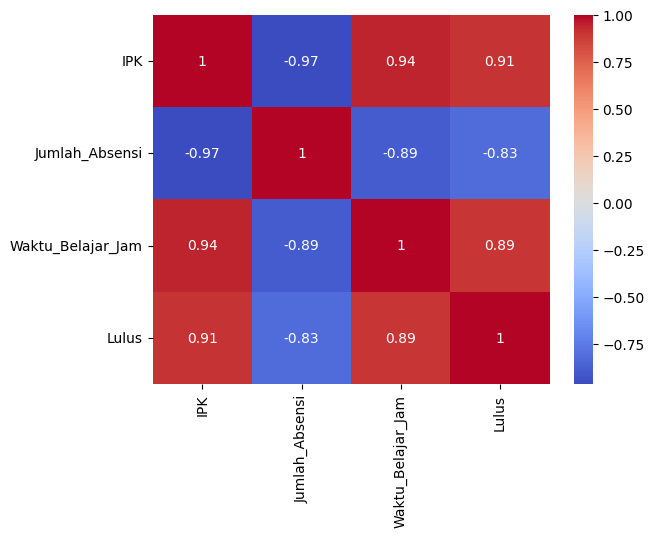

In [77]:
import matplotlib.pyplot as plt
print(df.describe())
sns.histplot(df['IPK'], bins=10, kde=True)
plt.show()
sns.scatterplot(x='IPK', y='Waktu_Belajar_Jam', data=df, hue='Lulus')
plt.show()
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

Langkah 5 — Feature Engineering
Buat fitur turunan baru:

In [78]:
df['Rasio_Absensi'] = df['Jumlah_Absensi'] / 14
df['IPK_x_Study'] = df['IPK'] * df['Waktu_Belajar_Jam']
df.to_csv("processed_kelulusan.csv", index=False)

Langkah 6 — Splitting Dataset
Bagi dataset menjadi Train (70%), Validation (15%), Test (15%) menggunakan stratified split:

In [79]:
from sklearn.model_selection import train_test_split

X = df.drop('Lulus', axis=1)
y = df['Lulus']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(7, 5) (1, 5) (2, 5)


In [80]:
X_val.to_csv("X_val.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
X_train.to_csv("X_train.csv", index=False)
y_val.to_csv("Y_val.csv", index=False)
y_test.to_csv("Y_test.csv", index=False)
y_train.to_csv("Y_train.csv", index=False)



In [81]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np
# Pisahkan fitur dan target
X = df.drop('Lulus', axis=1)
y = df['Lulus']

# Pisahkan sebagian data sebagai test set (misalnya 15%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Inisialisasi model
model = LogisticRegression(max_iter=1000)

# Gunakan 5-fold cross validation di data training
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

print("Akurasi tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))

# Setelah puas dengan hasil CV, latih ulang di seluruh data training
model.fit(X_train, y_train)

# Uji performa akhir di test set
test_score = model.score(X_test, y_test)
print("Akurasi pada test set:", test_score)


Akurasi tiap fold: [1. 1. 1. 1. 1.]
Rata-rata akurasi: 1.0
Akurasi pada test set: 1.0


PERTEMUAN 5 - LANJUTAN

Langkah 1 — Muat Data
Pilihan A (pakai file split dari Pertemuan 4):

In [82]:
import pandas as pd

X_train = pd.read_csv("X_train.csv")
X_val = pd.read_csv("X_val.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("Y_train.csv").squeeze("columns")
y_val = pd.read_csv("Y_val.csv").squeeze("columns")
y_test = pd.read_csv("Y_test.csv").squeeze("columns")

print(X_train.shape, X_val.shape, X_test.shape)

(7, 5) (1, 5) (2, 5)


Langkah 2 — Baseline Model & Pipeline
Bangun baseline terstandar menggunakan Logistic Regression + pipeline preprocessing.

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

num_cols = X_train.select_dtypes(include="number").columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
], remainder="drop")

logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
pipe_lr = Pipeline([("pre", pre), ("clf", logreg)])

pipe_lr.fit(X_train, y_train)
y_val_pred = pipe_lr.predict(X_val)
print("Baseline (LogReg) F1(val):", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred, digits=3))

Baseline (LogReg) F1(val): 1.0
              precision    recall  f1-score   support

           1      1.000     1.000     1.000         1

    accuracy                          1.000         1
   macro avg      1.000     1.000     1.000         1
weighted avg      1.000     1.000     1.000         1



Langkah 3 — Model Alternatif (Random Forest)

In [84]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt", class_weight="balanced", random_state=42
)
pipe_rf = Pipeline([("pre", pre), ("clf", rf)])

pipe_rf.fit(X_train, y_train)
y_val_rf = pipe_rf.predict(X_val)
print("RandomForest F1(val):", f1_score(y_val, y_val_rf, average="macro"))

RandomForest F1(val): 1.0


Langkah 4 — Validasi Silang & Tuning Ringkas

In [85]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
param = {
  "clf__max_depth": [None, 12, 20, 30],
  "clf__min_samples_split": [2, 5, 10]
}
gs = GridSearchCV(pipe_rf, param_grid=param, cv=skf,
                  scoring="f1_macro", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV F1:", gs.best_score_)

best_rf = gs.best_estimator_
y_val_best = best_rf.predict(X_val)
print("Best RF F1(val):", f1_score(y_val, y_val_best, average="macro"))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2}
Best CV F1: 1.0
Best RF F1(val): 1.0


Langkah 5 — Evaluasi Akhir (Test Set)

F1(test): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2

Confusion matrix (test):
[[2]]


d:\machine_learning\.venv\lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
d:\machine_learning\.venv\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
d:\machine_learning\.venv\lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ROC-AUC(test): nan


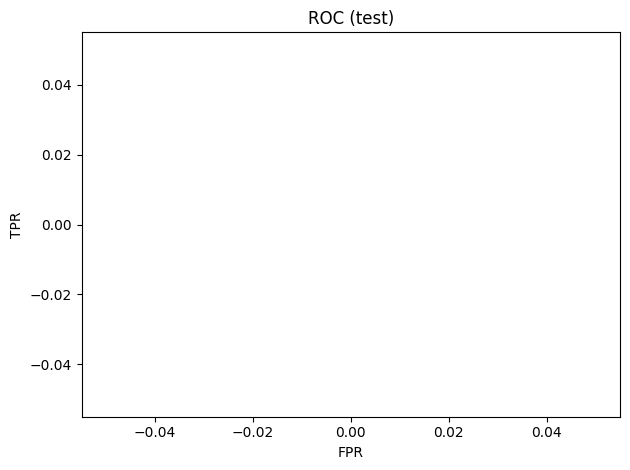

In [86]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

final_model = best_rf  # atau pipe_lr jika baseline lebih baik
y_test_pred = final_model.predict(X_test)

print("F1(test):", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

# ROC-AUC (jika ada predict_proba)
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:,1]
    try:
        print("ROC-AUC(test):", roc_auc_score(y_test, y_test_proba))
    except:
        pass
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
    plt.tight_layout(); plt.savefig("roc_test.png", dpi=120)

Langkah 6 (Opsional) — Simpan Model

In [87]:
import joblib
joblib.dump(final_model, "model.pkl")
print("Model tersimpan ke model.pkl")

Model tersimpan ke model.pkl


Langkah 7 (Opsional) — Endpoint Inference (Flask)

In [88]:
from flask import Flask, request, jsonify
import joblib, pandas as pd

app = Flask(__name__)
MODEL = joblib.load("model.pkl")

# Tambahkan index route
@app.route("/", methods=["GET"])
def home():
    return jsonify({
        "message": "Welcome to the Prediction API",
        "usage": "Send POST request to /predict with JSON body berisi fitur"
    })

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json(force=True)  # dict fitur
    X = pd.DataFrame([data])
    yhat = MODEL.predict(X)[0]
    proba = None
    if hasattr(MODEL, "predict_proba"):
        proba = float(MODEL.predict_proba(X)[:,1][0])
    return jsonify({"prediction": int(yhat), "proba": proba})

if __name__ == "__main__":
    app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


Lembar Kerja Pertemuan 6 — Random Forest untuk Klasifikasi

Langkah 2 — Pipeline & Baseline Random Forest
Bangun pipeline preprocessing & model agar bebas data leakage.

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

num_cols = X_train.select_dtypes(include="number").columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
], remainder="drop")

rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt",
    class_weight="balanced", random_state=42
)

pipe = Pipeline([("pre", pre), ("clf", rf)])
pipe.fit(X_train, y_train)

y_val_pred = pipe.predict(X_val)
print("Baseline RF — F1(val):", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred, digits=3))

Baseline RF — F1(val): 1.0
              precision    recall  f1-score   support

           1      1.000     1.000     1.000         1

    accuracy                          1.000         1
   macro avg      1.000     1.000     1.000         1
weighted avg      1.000     1.000     1.000         1



Langkah 3 — Validasi Silang

In [90]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="f1_macro", n_jobs=-1)
print("CV F1-macro (train):", scores.mean(), "±", scores.std())

CV F1-macro (train): 1.0 ± 0.0


Langkah 4 — Tuning Ringkas (GridSearch)

In [91]:
from sklearn.model_selection import GridSearchCV

param = {
  "clf__max_depth": [None, 12, 20, 30],
  "clf__min_samples_split": [2, 5, 10]
}

gs = GridSearchCV(pipe, param_grid=param, cv=skf,
                  scoring="f1_macro", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best_model = gs.best_estimator_
y_val_best = best_model.predict(X_val)
print("Best RF — F1(val):", f1_score(y_val, y_val_best, average="macro"))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2}
Best RF — F1(val): 1.0


Langkah 5 — Evaluasi Akhir (Test Set)

F1(test): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2

Confusion Matrix (test):
[[2]]
ROC-AUC(test): nan


d:\machine_learning\.venv\lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
d:\machine_learning\.venv\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
d:\machine_learning\.venv\lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
d:\machine_learning\.venv\lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


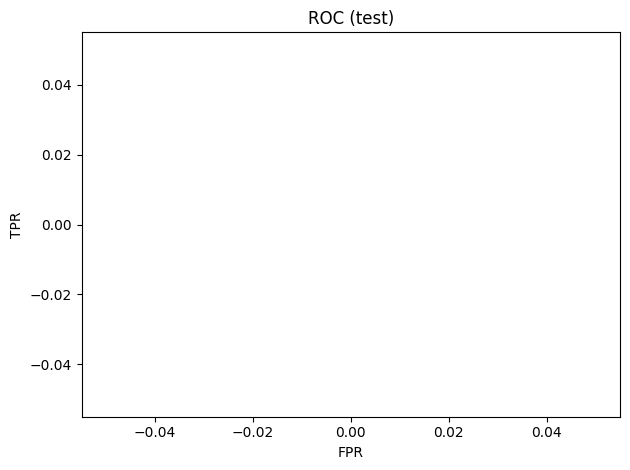

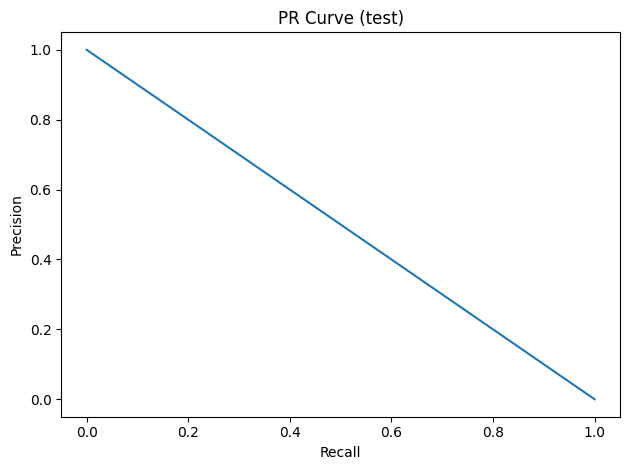

In [92]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

final_model = best_model  # pilih terbaik; jika baseline lebih baik, gunakan pipe

y_test_pred = final_model.predict(X_test)
print("F1(test):", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion Matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

# ROC-AUC (bila ada predict_proba)
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:,1]
    try:
        print("ROC-AUC(test):", roc_auc_score(y_test, y_test_proba))
    except:
        pass
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
    plt.tight_layout(); plt.savefig("roc_test.png", dpi=120)

    prec, rec, _ = precision_recall_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve (test)")
    plt.tight_layout(); plt.savefig("pr_test.png", dpi=120)

Langkah 6 — Pentingnya Fitur

In [93]:
# 6a) Feature importance native (gini)
try:
    import numpy as np
    importances = final_model.named_steps["clf"].feature_importances_
    fn = final_model.named_steps["pre"].get_feature_names_out()
    top = sorted(zip(fn, importances), key=lambda x: x[1], reverse=True)
    print("Top feature importance:")
    for name, val in top[:10]:
        print(f"{name}: {val:.4f}")
except Exception as e:
    print("Feature importance tidak tersedia:", e)

# 6b) (Opsional) Permutation Importance
# from sklearn.inspection import permutation_importance
# r = permutation_importance(final_model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
# ... (urutkan dan laporkan)

Top feature importance:
num__IPK: 0.2509
num__IPK_x_Study: 0.2096
num__Waktu_Belajar_Jam: 0.2062
num__Rasio_Absensi: 0.1856
num__Jumlah_Absensi: 0.1478


Langkah 7 — Simpan Model

In [94]:
import joblib
joblib.dump(final_model, "rf_model.pkl")
print("Model disimpan sebagai rf_model.pkl")

Model disimpan sebagai rf_model.pkl


Langkah 8 — Cek Inference Lokal

In [95]:
# Contoh sekali jalan (input fiktif), sesuaikan nama kolom:
import pandas as pd, joblib
mdl = joblib.load("rf_model.pkl")
sample = pd.DataFrame([{
  "IPK": 3.4,
  "Jumlah_Absensi": 4,
  "Waktu_Belajar_Jam": 7,
  "Rasio_Absensi": 4/14,
  "IPK_x_Study": 3.4*7
}])
print("Prediksi:", int(mdl.predict(sample)[0]))

Prediksi: 1
